This tutorial can be downloaded [link](http://greatfire.uchicago.edu/west-public/West/raw/master/Doc/tutorials/basic/basic_008.ipynb).

# Intro tutorial 8: Computing absorption spectra by solving the Bethe-Salpeter Equation (BSE)

This tutorial shows how to compute the absorption spectrum of the C60 molecule by solving the Bethe-Salpeter Equation (BSE). WEST adopts a finite field formalism to solve the BSE. The screened Coulomb interaction is directly evaluated in finite field, thus eliminating the need to compute dielectric matrices altogether. In addition, the computational cost can be reduced by using a localized representation of the ground state Kohn-Sham wavefunctions. For more information about the method, the reader is referred to [Nguyen et al., Phys. Rev. Lett. 122, 237402 (2019)](https://doi.org/10.1103/PhysRevLett.122.237402).

## Step 1:  Mean-field starting point

### Step 1.1: Mean-field calculation with Quantum ESPRESSO

We first perform the mean-field electronic structure calculation within DFT using the [Quantum ESPRESSO](https://www.quantum-espresso.org/) code.

Download the following files to your working directory:

In [ ]:
%%bash
wget -N -q http://www.west-code.org/doc/training/c60/pw.in
wget -N -q http://www.quantum-simulation.org/potentials/sg15_oncv/upf/C_ONCV_PBE-1.2.upf

We can inspect the `pw.in` file, the input for the `pw.x` code:

In [1]:
%%bash
cat pw.in

&control
pseudo_dir = './'
calculation = 'scf'
wf_collect = .TRUE.
/
&system
ibrav = 0
ntyp = 1
nat = 60
ecutwfc = 20
/
&electrons
diago_full_acc = .TRUE.
/
ATOMIC_SPECIES
C 14 C_ONCV_PBE-1.2.upf
ATOMIC_POSITIONS bohr
C  6.560216999227  1.317708999068  0.000000000000
C  5.716322000011  2.686502999941 -2.213027000418
C  6.560216999227 -1.317708999068  0.000000000000
C  4.900061000384  1.363055000501 -4.347289999376
C  2.686503999607  2.213028000083 -5.716321000346
C  4.347291000932  4.900060000718 -1.363055000501
C  2.213028000083  5.716322000011 -2.686502000276
C  1.363056000166  4.347291000932 -4.900058999163
C  4.900058999163 -1.363055000501  4.347289999376
C  4.900058999163  1.363055000501  4.347289999376
C  5.716321000346 -2.686502999941  2.213027000418
C  5.716321000346  2.686502999941  2.213027000418
C  4.347291000932  4.900060000718  1.363055000501
C  2.686501000610  2.213028000083  5.716321000346
C  1.363054000835  4.347291000932  4.900058999163
C  2.213027000418  5.71632200001

We run `pw.x` on 32 cores.

In [ ]:
%%bash
mpirun -n 32 pw.x -i pw.in > pw.out

We need to include several unoccupied bands (in this case 800 bands in total) by running a non-self-consistent calculation. Download the input file to your working directory:

In [ ]:
%%bash
wget -N -q http://www.west-code.org/doc/training/c60/nscf.in

The content of `nscf.in` is almost identical to that of `pw.in`, except that in `nscf.in` we request a non-self-consistent calculation with empty bands.

In [2]:
%%bash
cat nscf.in

&control
pseudo_dir = './'
calculation = 'nscf'
wf_collect = .TRUE.
/
&system
ibrav = 0
ntyp = 1
nat = 60
ecutwfc = 20
nbnd = 800
/
&electrons
diago_full_acc = .TRUE.
/
ATOMIC_SPECIES
C 14 C_ONCV_PBE-1.2.upf
ATOMIC_POSITIONS bohr
C  6.560216999227  1.317708999068  0.000000000000
C  5.716322000011  2.686502999941 -2.213027000418
C  6.560216999227 -1.317708999068  0.000000000000
C  4.900061000384  1.363055000501 -4.347289999376
C  2.686503999607  2.213028000083 -5.716321000346
C  4.347291000932  4.900060000718 -1.363055000501
C  2.213028000083  5.716322000011 -2.686502000276
C  1.363056000166  4.347291000932 -4.900058999163
C  4.900058999163 -1.363055000501  4.347289999376
C  4.900058999163  1.363055000501  4.347289999376
C  5.716321000346 -2.686502999941  2.213027000418
C  5.716321000346  2.686502999941  2.213027000418
C  4.347291000932  4.900060000718  1.363055000501
C  2.686501000610  2.213028000083  5.716321000346
C  1.363054000835  4.347291000932  4.900058999163
C  2.213027000418  5

We run `pw.x` again on 32 cores.

In [ ]:
%%bash
mpirun -n 32 pw.x -i nscf.in > nscf.out

### Step 1.2: Mean-field calculation with Qbox

Next we repeat the mean-field electronic structure calculation using the [Qbox](http://qboxcode.org/) code.

Download the following files to your working directory:

In [ ]:
%%bash
wget -N -q http://www.west-code.org/doc/training/c60/qb.in
wget -N -q http://www.quantum-simulation.org/potentials/sg15_oncv/xml/C_ONCV_PBE-1.2.xml

We can inspect the `qb.in` file, the input for the `qb` code:

In [3]:
%%bash
cat qb.in

set cell 30.0 0.0 0.0  0.0 30.0 0.0  0.0 0.0 30.0
species carbon C_ONCV_PBE-1.2.xml
atom C1 carbon  6.560216999227  1.317708999068  0.000000000000
atom C2 carbon  5.716322000011  2.686502999941 -2.213027000418
atom C3 carbon  6.560216999227 -1.317708999068  0.000000000000
atom C4 carbon  4.900061000384  1.363055000501 -4.347289999376
atom C5 carbon  2.686503999607  2.213028000083 -5.716321000346
atom C6 carbon  4.347291000932  4.900060000718 -1.363055000501
atom C7 carbon  2.213028000083  5.716322000011 -2.686502000276
atom C8 carbon  1.363056000166  4.347291000932 -4.900058999163
atom C9 carbon  4.900058999163 -1.363055000501  4.347289999376
atom C10 carbon  4.900058999163  1.363055000501  4.347289999376
atom C11 carbon  5.716321000346 -2.686502999941  2.213027000418
atom C12 carbon  5.716321000346  2.686502999941  2.213027000418
atom C13 carbon  4.347291000932  4.900060000718  1.363055000501
atom C14 carbon  2.686501000610  2.213028000083  5.716321000346
atom C15 carbon  1.3630540008

We use the same atomic positions, exchange-correlation functional, cutoff energy, and pseudopotential for `qb` as used for `pw.x` in the previous step. Check out the [Qbox documentation](http://qboxcode.org/doc/html/) for more information about how to operate the code.

We run `qb` on 32 cores.

In [ ]:
%%bash
mpirun -n 32 qb < qb.in > qb.out

The information of the ground state calculation, including the Kohn-Sham wavefunctions, is stored in the file `qb.gs.xml`. Now we localize the ground state wavefunctions using the recursive subspace bisection technique implemented in Qbox. Download the input file to your working directory:

In [ ]:
%%bash
wget -N -q http://www.west-code.org/doc/training/c60/qb2.in

We can inspect the `qb2.in` file:

In [4]:
%%bash
cat qb2.in

load qb.gs.xml

bisection 5 5 5 0.0316
save qb.bis.0.0316.xml

set xc HF
set btHF 0.0316
set blHF 5 5 5

set wf_dyn LOCKED

run 0


We run `qb` again on 32 cores.

In [ ]:
%%bash
mpirun -n 32 qb < qb2.in > qb2.out

`qb` will localize the wavefunctions stored in `qb.gs.xml`, then write the localized wavefunctions to the file `qb.bis.0.0316.xml`. We use the [WESTpy Python package](http://www.west-code.org/doc/westpy/latest/) to parse the Qbox output files.

In [ ]:
from westpy.bse import *

qb = Qbox2BSE("qb2.out")
qb.write_localization()
qb.write_wavefunction()

This should generate two files, namely `bis_info.1` containing bisection localization information and `qb_wfc.1` containing localized wavefunctions in the HDF5 format. The extension, `.1`, denotes the spin channel. Both files will be used in the BSE calculation.

## Step 2: GW quasiparticle correction with WEST

We compute GW quasiparticle energies following the steps detailed in [Tutorial 1](http://greatfire.uchicago.edu/west-public/West/raw/master/Doc/tutorials/basic/basic_001.ipynb), then use WESTpy to parse the output file:

In [ ]:
from westpy.bse import *

qp = Wfreq2BSE("west.wfreq.save/wfreq.json")
qp.write_qp_correction()

This should generate a file called `qp_eig.1`, which contains the quasiparticle energies and will be used in the BSE calculation. The extension, `.1`, denotes the spin channel.

## Step 3: BSE calculation with WEST

### Step 3.1: BSE initialization

We perform an initialization step using the `wbse_init.x` executable. Download the following files to your working directory:

In [ ]:
%%bash
wget -N -q http://www.west-code.org/doc/training/c60/wbse_init.in

Let us inspect the `wbse_init.in` file:

In [5]:
%%bash
cat wbse_init.in

input_west:
  outdir: ./

wbse_init_control:
  wbse_init_calculation: S
  localization: B

server_control:
  document: {"response": {"amplitude": 0, "nitscf": 20, "nite": 0}, "script": ["load ./qb.gs.xml \n set xc PBE \n set wf_dyn PSDA \n set blHF 2 2 2 \n set btHF    0.00 \n"]}


The `localization: B` keyword instructs the code to use wavefunctions localized by the recursive subspace bisection method implemented in Qbox. If two localized wavefunctions do not overlap with each other, the evaluation of the corresponding screened exchange integral is skipped, thus reducing the computational cost. Localized wavefunctions and bisection information are read from files `bis_info.1` and `qb_wfc.1` obtained in Step 1.2.

The `document` keyword in the `server_control` section is used to run WEST and Qbox in the client-server mode. In this mode, we run `wbse_init.x` together with multiple instances of `qb`. The client, `wbse_init.x`, dispatches finite field calculations to the server, `qb`. Each instance of `qb` computes the density response to the finite electric field. An example script to run such a calculation looks as follows:

In [ ]:
%%bash
nimages=8

# Submit nimages instances of Qbox (each instance runs on 32 cores)

for (( i=0; i<$nimages; i++ ))
do
    qb_in=`printf "qb.%d.in" $i`
    qb_out=`printf "qb.%d.out" $i`
    mpirun -n 32 ./qb -server $qb_in $qb_out &
    sleep 1
done

# Submit 1 instance of WEST (it runs on 32 cores)
mpirun -n 32 ./wbse_init.x -ni $nimages -i wbse_init.in > wbse_init.out &
wait

The user must request computational resources for `wbse_init.x` and all instances of `qb`. In this example, we run `wbse_init.x` with eight instances of `qb`, requesting $32 \times (1+8) = 288$ cores.

### Step 3.2: BSE

Now we can carry out the main BSE calculation using the `wbse.x` executable. Download the following files to your working directory:

In [ ]:
%%bash
wget -N -q http://www.west-code.org/doc/training/c60/wbse.in

Let us inspect the `wbse.in` file:

In [6]:
%%bash
cat wbse.in

input_west:
  outdir: ./

wbse_init_control:
  wbse_init_calculation: S
  localization: B

server_control:
  document: {"response": {"amplitude": 0, "nitscf": 20, "nite": 0}, "script": ["load ./qb.gs.xml \n set xc PBE \n set wf_dyn PSDA \n set blHF 2 2 2 \n set btHF    0.00 \n"]}

wbse_control:
  wbse_calculation: L
  qp_correction: qp_eig
  ipol_input: XYZ
  n_lanczos: 1300


The `wbse_calculation: L` keyword instructs the code to compute absorption spectra using the Liouville-Lanczos algorithm. The `qp_correction: qp_eig` keyword specifies the name of the file that contains the quasiparticle correction. An extension of `.1`, corresponding to spin channel 1, will be automatically appended to the file name. The `ipol_input: XYZ` keyword specifies which components of the polarizability tensor are computed, where `XYZ` means that three Lanczos chains are sequentially performed to compute the full polarizability tensor.

We run `wbse.x` on 512 cores:

In [ ]:
%%bash
mpirun -n 512 ./wbse.x -ni 16 -i wbse.in > wbse.out

By specifying `-ni 16`, we launch `wbse.x` with 16 images. The overlapping pairs of wavefunctions are distributed across the images to evaluate the screened exchange integral in parallel.

The output can be found in the file `west.wbse.save/wbse.json`. If the reader does NOT have the computational resources to run the calculations, the output file can be directly downloaded as:

In [ ]:
%%bash
mkdir -p west.wbse.save
wget -N -q http://www.west-code.org/doc/training/c60/wbse.json -O west.wbse.save/wbse.json

We use WESTpy to parse this file and plot the absorption coefficient as a function of the photon frequency.

 
 _    _ _____ _____ _____            
| |  | |  ___/  ___|_   _|           
| |  | | |__ \ `--.  | |_ __  _   _  
| |/\| |  __| `--. \ | | '_ \| | | | 
\  /\  / |___/\__/ / | | |_) | |_| | 
 \/  \/\____/\____/  \_/ .__/ \__, | 
                       | |     __/ | 
                       |_|    |___/  
 
WEST version     :  5.2.0
Today            :  2022-12-14 19:03:26.038641
output written in :  chi_XYZ.png
waiting for user to close image preview...


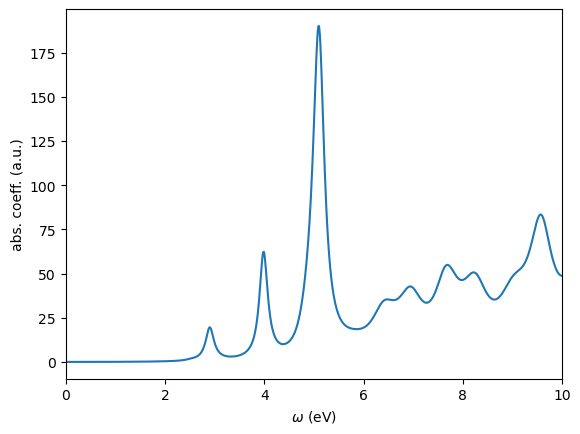

In [7]:
from westpy.bse import *

wbse = BSEResult("west.wbse.save/wbse.json")
wbse.plotSpectrum(ipol="XYZ",energyRange=[0.0,10.0,0.01],sigma=0.1,n_extra=98700)